In [12]:
import pandas as pd
import numpy as np
import warnings; 
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
#from sklearn.preprocessing import CategoricalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier



## Creating Test/Train Sets

In [41]:
# this is to toggle the 2 types of time course variables
flag_tc = 0

if flag_tc:   
    tc_cols = ['tracid_gr_1_10d','tracid_gr_11_20d',
           'tracid_gr_21_30d', 'tracid_gr_31_40d', 'tracid_gr_41_50d',
            'tracid_gr_51_60d', 'tracid_gr_61_70d',
           'tracid_gr_71_80d', 'tracid_gr_81_90d','tracid_gr_91_100d']
else:
    tc_cols = ['nat_gr_1yr', 'nat_gr_2yr','nat_gr_3yr','nat_gr_4yr','nat_gr_5yr',
                'nat_gr_6yr','nat_gr_7yr','nat_gr_8yr','nat_gr_9yr','nat_gr_10yr']

In [42]:
# loading appropriate files
path = '/data/WorkData/spatialtemporal/'
file = pd.read_csv(path + 'finalmerge_any_late.csv')
timefile = pd.read_csv(path + 'gr_lastyear_late.csv')
extra_timefile = pd.read_csv('/data/WorkData/spatialtemporal/extra_timefeatures_late.csv')
test_cases = pd.read_csv(path + 'test_cases_last_hearing.csv', header=None)

In [43]:
file.columns

Index(['idncase', 'idnproceeding', 'dec', 'numAppsPerProc', 'nat', 'case_type',
       'c_asy_type', 'base_city_code', 'hearing_loc_code', 'osc_date',
       'comp_date', 'attorney_flag', 'tracid', 'hearing_city', 'base_city',
       'numProcPerCase', 'adj_medium', 'adj_date', 'sched_type',
       'lang_hearing', 'notice_desc', 'adj_time_start2', 'adj_time_stop2',
       'durationHearing', 'adj_rsn_desc', 'numHearingsPerProc',
       'durationFirstLastHearing', 'averageHearingDur', 'pres_aff',
       'osc_date_delta', 'caseDuration', 'hearingDayOfWeek', 'hearingYear',
       'hearingMonth'],
      dtype='object')

In [44]:

file = pd.merge(file, timefile, on=['idnproceeding','idncase'])

file = pd.merge(file, pd.concat((extra_timefile['idnproceeding'],extra_timefile[tc_cols]),axis=1), on='idnproceeding')



In [45]:
# get training data set
test_cases = test_cases.rename(columns={0:'num'})
train = file[~file.idncase.isin(test_cases.num)]

In [46]:
train.columns

Index(['idncase', 'idnproceeding', 'dec', 'numAppsPerProc', 'nat', 'case_type',
       'c_asy_type', 'base_city_code', 'hearing_loc_code', 'osc_date',
       'comp_date', 'attorney_flag', 'tracid', 'hearing_city', 'base_city',
       'numProcPerCase', 'adj_medium', 'adj_date', 'sched_type',
       'lang_hearing', 'notice_desc', 'adj_time_start2', 'adj_time_stop2',
       'durationHearing', 'adj_rsn_desc', 'numHearingsPerProc',
       'durationFirstLastHearing', 'averageHearingDur', 'pres_aff',
       'osc_date_delta', 'caseDuration', 'hearingDayOfWeek', 'hearingYear',
       'hearingMonth', 'nat_num_last1yr_late', 'nat_gr_last1yr_late',
       'nat_dmy_last1yr_late', 'tracid_num_last1yr_late',
       'tracid_gr_last1yr_late', 'tracid_dmy_last1yr_late',
       'base_city_code_num_last1yr_late', 'base_city_code_gr_last1yr_late',
       'base_city_code_dmy_last1yr_late', 'tracid_gr_last10d',
       'tracid_dmy_last10d', 'nat_gr_1yr', 'nat_gr_2yr', 'nat_gr_3yr',
       'nat_gr_4yr', 'nat_g

In [47]:
cols =  ['dec','tracid','nat','attorney_flag','c_asy_type','case_type']+tc_cols
train_data = train[cols]

In [48]:
train_data.columns

Index(['dec', 'tracid', 'nat', 'attorney_flag', 'c_asy_type', 'case_type',
       'nat_gr_1yr', 'nat_gr_2yr', 'nat_gr_3yr', 'nat_gr_4yr', 'nat_gr_5yr',
       'nat_gr_6yr', 'nat_gr_7yr', 'nat_gr_8yr', 'nat_gr_9yr', 'nat_gr_10yr'],
      dtype='object')

In [49]:
# change variables that are incorrect dtypes

train_data['tracid'] = train_data['tracid'].astype('str')
train_data['nat'] = train_data['nat'].astype('str')
train_data['case_type'] = train_data['case_type'].astype('str')
train_data['c_asy_type'] = train_data['c_asy_type'].astype('str')


    

In [50]:
# last minute inspection of dtypes to make sure they are correct
train_data.dtypes

dec              float64
tracid            object
nat               object
attorney_flag    float64
c_asy_type        object
case_type         object
nat_gr_1yr       float64
nat_gr_2yr       float64
nat_gr_3yr       float64
nat_gr_4yr       float64
nat_gr_5yr       float64
nat_gr_6yr       float64
nat_gr_7yr       float64
nat_gr_8yr       float64
nat_gr_9yr       float64
nat_gr_10yr      float64
dtype: object

In [51]:
y_train = train_data['dec']
X_train = train_data.drop(columns=['dec'], axis=1)

## Generating Pipeline

In [52]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        num_frame = X.select_dtypes(include=[self.dtype])
        self.names = num_frame.columns
        return num_frame
    def get_feature_names(self):
        return self.names.tolist()

In [53]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #X = np.asarray(pd.get_dummies(X))
        #self.names = X.columns 
        self.names = np.array(0)
        self.orig_classes = np.array(0)
        for col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            #cat_frame = X.apply(le.fit_transform)
            self.names = np.append(self.names, le.classes_)
            c_list = np.array(0)
            for f in le.classes_:
                c_list = np.append(c_list,col)
            c_list = c_list[1:]
            self.orig_classes = np.append(self.orig_classes, c_list)
        self.names = self.names[1:]
        self.orig_classes =  self.orig_classes[1:]
    
        return X
    def get_feature_names(self):
        return self.names.tolist()
    def get_orig_classes(self): 
        # returns original variable type of the feature, i.e. nat
        return self.orig_classes.tolist()

In [54]:
num_pipeline = Pipeline([
        ('selector', Selector(np.number)),
        ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
        ('selector', Selector('object')),
        ('labeler', CustomLabelEncoder())
        #('encoder', OneHotEncoder()),
]) 

full_pipeline = FeatureUnion(transformer_list=[ 
        ('numerical', num_pipeline),  
        ('categorical', cat_pipeline)   
])  

In [55]:
cat_pipeline_reg = Pipeline([
        ('selector', Selector('object')),
        ('labeler', CustomLabelEncoder()),
        ('encoder', OneHotEncoder())
]) 

full_pipeline_reg = FeatureUnion(transformer_list=[ 
        ('numerical', num_pipeline),  
        ('categorical', cat_pipeline_reg)   
])  

## Pipeline-for regression models
### (categorical variables one hot encoded)

In [56]:
X_train_tr_reg = full_pipeline_reg.fit_transform(X_train)

In [57]:
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline_reg.named_steps['labeler'].get_feature_names()
cat_classes = cat_pipeline_reg.named_steps['labeler'].get_orig_classes()
num_features

['attorney_flag',
 'nat_gr_1yr',
 'nat_gr_2yr',
 'nat_gr_3yr',
 'nat_gr_4yr',
 'nat_gr_5yr',
 'nat_gr_6yr',
 'nat_gr_7yr',
 'nat_gr_8yr',
 'nat_gr_9yr',
 'nat_gr_10yr']

## Hyperparameter Grid Search On Logistic Regression

In [58]:
c_vec = 10**np.arange(-5,1).astype('float64')
param_grid = { 'C': c_vec}


In [59]:
log_reg = LogisticRegression(penalty='l2')
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train_tr_reg, y_train)
result = pd.DataFrame(grid_search.cv_results_)

In [60]:
print(result)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       1.846872         0.069104         0.804727          0.793958   1e-05   
1       3.238727         0.066576         0.805005          0.810395  0.0001   
2       5.906791         0.107801         0.799147          0.829426   0.001   
3      10.809715         0.061024         0.797542          0.850974    0.01   
4      14.440365         0.053802         0.793808          0.856188     0.1   
5      17.452223         0.038009         0.791909          0.856678       1   

          params  rank_test_score  split0_test_score  split0_train_score  \
0   {'C': 1e-05}                2           0.748140            0.807806   
1  {'C': 0.0001}                1           0.774221            0.826278   
2   {'C': 0.001}                3           0.777627            0.844239   
3    {'C': 0.01}                4           0.777208            0.863520   
4     {'C': 0.1}                5           0.777653       

In [61]:
final_model = grid_search.best_estimator_
feature_weight = np.abs(grid_search.best_estimator_.coef_[0])

([<matplotlib.axis.YTick at 0x7f9429c4f780>,
 <a list of 10 Text yticklabel objects>)

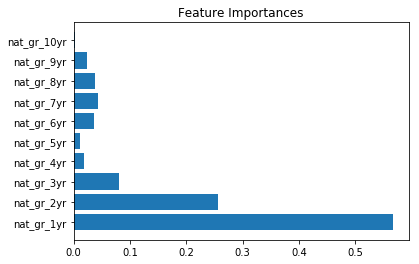

In [62]:
#  weights --just time features
num_features = num_pipeline.named_steps['selector'].get_feature_names()
indices = [i for i in range(len(num_features)) if num_features[i] in tc_cols]

plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight[indices], align='center')
plt.yticks(range(len(indices)), [num_features[i] for i in indices])


array([0.35735963, 0.5660048 , 0.25695048, 0.080542  , 0.01807568,
       0.01122183, 0.03673228, 0.04286133, 0.03790376, 0.02316663,
       0.00221167, 0.01218836, 0.00428617, 0.16767631, 0.05133141])

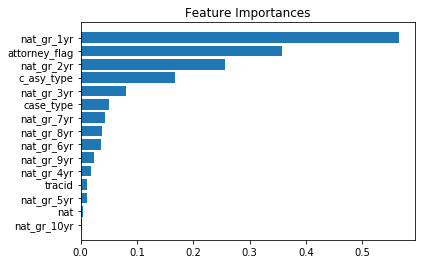

In [63]:
# all weights

num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline_reg.named_steps['labeler'].get_feature_names()
cat_classes = cat_pipeline_reg.named_steps['labeler'].get_orig_classes()
attributes = np.append(num_features,pd.unique(cat_classes)) 
attributes_long = num_features + cat_classes #for each of >1000 feature, lists original feature name, i.e. nat or tracid
feature_weight_simple = np.zeros(len(attributes))
for i in range(len(attributes)):
    weights = feature_weight[[x == attributes[i] for x in attributes_long]]
    feature_weight_simple[i] = np.mean(weights)
    
indices = np.argsort(feature_weight_simple)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight_simple[indices], align='center')
plt.yticks(range(len(indices)), [attributes[i] for i in indices])
feature_weight_simple